In [4]:
from __future__ import annotations

import pickle

import ase

with open("/mnt/shared/jmp-distributions-all-11-4/ase_atoms_list.pkl", "rb") as f:
    dataset_to_atoms_list: dict[str, list[ase.Atoms]] = pickle.load(f)

print(dataset_to_atoms_list.keys())

# Find the dataset with the smallest size and trim all datasets to that size
min_size = min(len(atoms_list) for atoms_list in dataset_to_atoms_list.values())
# min_size = 10
print(min_size)

for dataset, atoms_list in dataset_to_atoms_list.items():
    dataset_to_atoms_list[dataset] = atoms_list[:min_size]

print(
    {dataset: len(atoms_list) for dataset, atoms_list in dataset_to_atoms_list.items()}
)

dict_keys(['mptrj', 'wbm', 'oc20', 'oc22', 'ani1x', 'trans1x'])
9000
{'mptrj': 9000, 'wbm': 9000, 'oc20': 9000, 'oc22': 9000, 'ani1x': 9000, 'trans1x': 9000}


  0%|          | 0/9000 [00:00<?, ?it/s]

100%|██████████| 9000/9000 [00:03<00:00, 2430.23it/s]


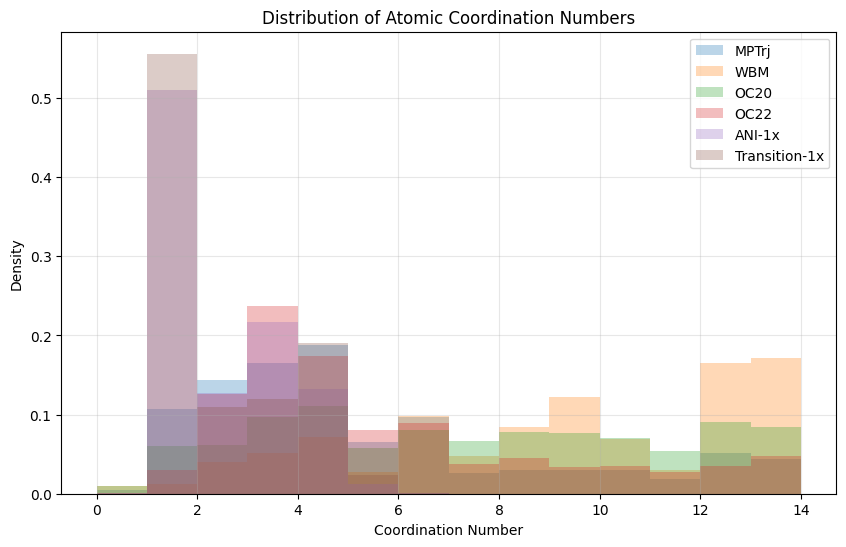

In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from ase.atoms import Atoms
from ase.neighborlist import NeighborList, natural_cutoffs
from tqdm import tqdm


def get_coord_numbers_fast(
    atoms_list: list[Atoms],
    sample_size: int | None = None,
    random_seed: int = 42,
    progress_bar: bool = True,
) -> list[int]:
    """
    Compute coordination numbers using cutoff-based neighbor lists.

    Args:
        atoms_list: List of ase.Atoms objects
        sample_size: Number of structures to sample (None for all)
        random_seed: Random seed for sampling
        progress_bar: Whether to show progress bar

    Returns:
        List of coordination numbers for all atoms in sampled structures
    """
    # Sample structures if needed
    if sample_size is not None and sample_size < len(atoms_list):
        rng = np.random.default_rng(random_seed)
        atoms_list = rng.choice(atoms_list, size=sample_size, replace=False)

    coord_numbers: list[int] = []
    iterator = tqdm(atoms_list) if progress_bar else atoms_list

    for atoms in iterator:
        # Get natural cutoffs for each atom type
        cutoffs = natural_cutoffs(atoms)
        # Initialize neighbor list
        nl = NeighborList(cutoffs, skin=0.3, self_interaction=False, bothways=True)
        nl.update(atoms)

        # Get coordination numbers for each atom
        for i in range(len(atoms)):
            indices, offsets = nl.get_neighbors(i)
            coord_numbers.append(len(indices))

    return coord_numbers


# Example usage:
datasets: dict[str, list[int]] = {
    # 'mptrj': get_coord_numbers_fast(mptrj_structures, sample_size=1000),
    # 'wbm': get_coord_numbers_fast(wbm_structures, sample_size=1000),
    # 'oc20': get_coord_numbers_fast(oc20_structures, sample_size=1000),
    # 'oc22': get_coord_numbers_fast(oc22_structures, sample_size=1000),
    # 'ani1x': get_coord_numbers_fast(ani1x_structures, sample_size=1000),
    # 'transition1x': get_coord_numbers_fast(transition1x_structures, sample_size=1000)
    dataset: get_coord_numbers_fast(atoms_list)
    for dataset, atoms_list in dataset_to_atoms_list.items()
}


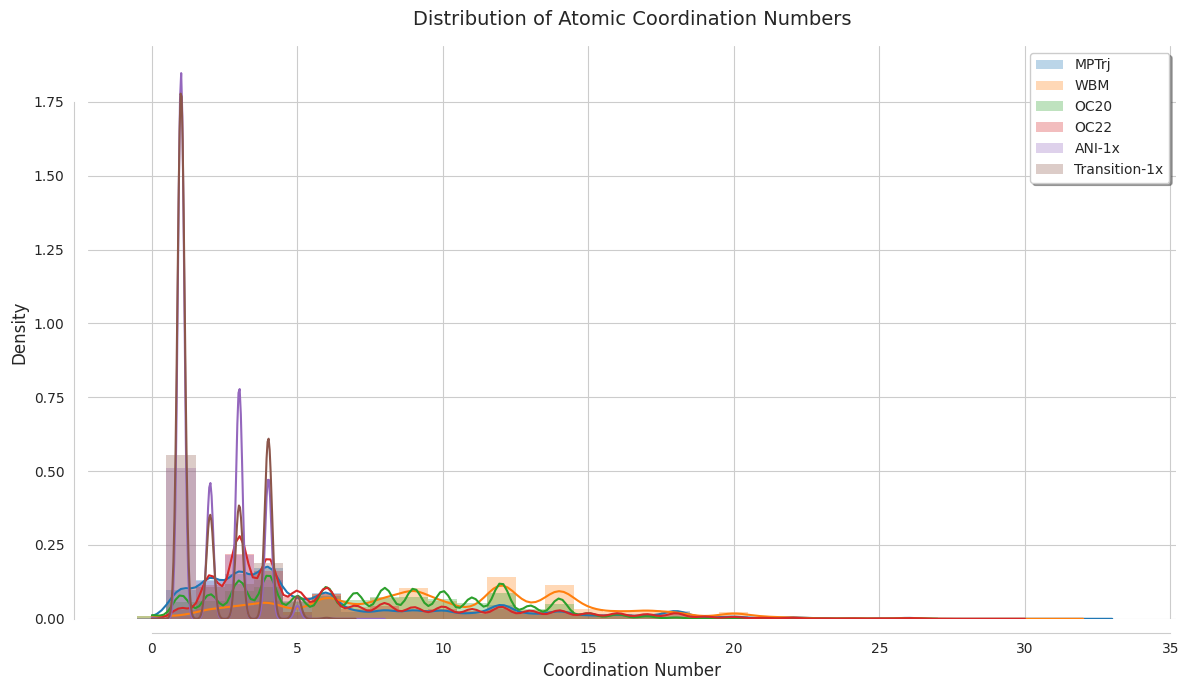

In [7]:
import seaborn as sns


def plot_coord_distributions(
    datasets: dict[str, list[int]],
    labels: dict[str, str],
    colors: dict[str, str],
    save_path: str | None = None,
) -> None:
    """
    Plot coordination number distributions for multiple datasets.

    Args:
        datasets: Dictionary of dataset name -> list of coordination numbers
        labels: Dictionary of dataset name -> display label
        colors: Dictionary of dataset name -> plot color
        save_path: Path to save figure (optional)
    """
    # Set style
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))

    # Plot each dataset
    for name in datasets:
        data: list[int] = datasets[name]
        sns.histplot(
            data=data,
            discrete=True,
            kde=True,
            stat="density",
            color=colors[name],
            label=labels[name],
            alpha=0.3,
            edgecolor="none",
            bins=np.arange(0, 15, 1),
        )

    plt.xlabel("Coordination Number", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title("Distribution of Atomic Coordination Numbers", fontsize=14, pad=15)
    plt.legend(frameon=True, fancybox=True, shadow=True)

    # Clean up the plot
    sns.despine(offset=10, trim=True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


labels: dict[str, str] = {
    "mptrj": "MPTrj",
    "wbm": "WBM",
    "oc20": "OC20",
    "oc22": "OC22",
    "ani1x": "ANI-1x",
    "trans1x": "Transition-1x",
}

colors: dict[str, str] = {
    "mptrj": "#1f77b4",
    "wbm": "#ff7f0e",
    "oc20": "#2ca02c",
    "oc22": "#d62728",
    "ani1x": "#9467bd",
    "trans1x": "#8c564b",
}

plot_coord_distributions(datasets, labels, colors, "coord_distributions.pdf")
# # For element-specific analysis (e.g., for transition metals)
# elements_of_interest = ['Cu', 'Fe', 'Ni', 'Pt', 'Pd']
# plot_element_specific_coord(
#     mptrj_structures,
#     elements_of_interest,
#     sample_size=1000
# )

Processing mptrj...


100%|██████████| 9000/9000 [00:57<00:00, 157.00it/s]


Processing wbm...


100%|██████████| 9000/9000 [00:25<00:00, 349.21it/s]


Processing pretrain...


100%|██████████| 36000/36000 [02:43<00:00, 220.59it/s] 


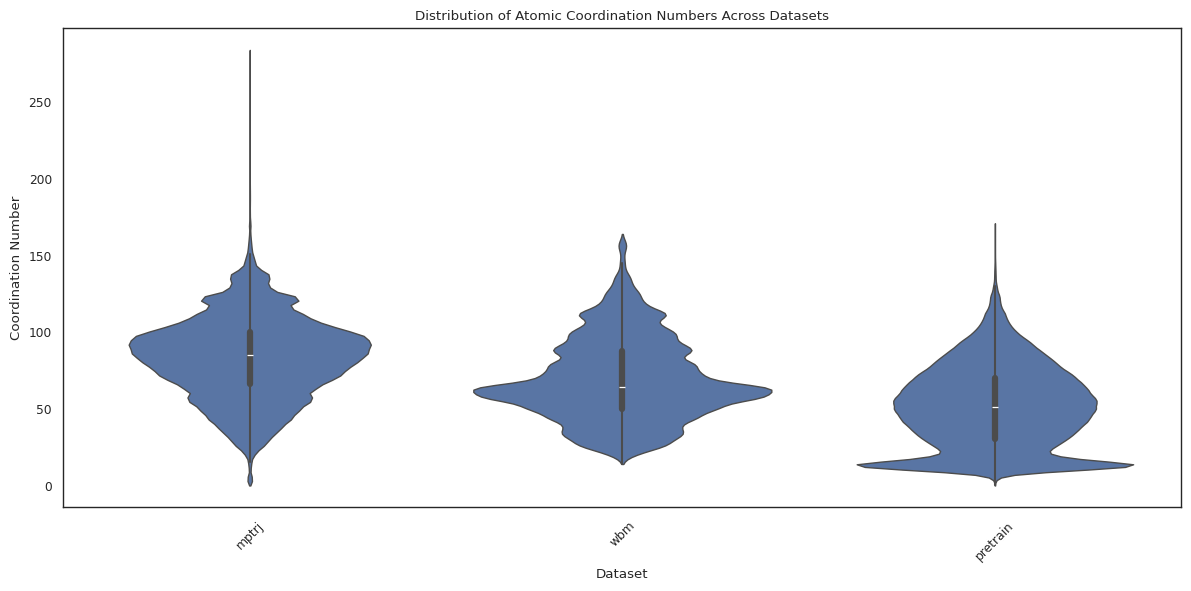


Summary Statistics:

mptrj:
  Mean: 83.36
  Median: 85.00
  Std: 26.47
  Most common: 92

wbm:
  Mean: 69.20
  Median: 64.00
  Std: 26.70
  Most common: 58

pretrain:
  Mean: 51.18
  Median: 51.00
  Std: 26.72
  Most common: 13


In [19]:
import copy
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ase.neighborlist import NeighborList
from tqdm import tqdm

sns.set_theme("paper", style="white")


def get_coordination_numbers(atoms, cutoff=3.0):
    """Calculate coordination numbers for all atoms in the structure."""
    # Create neighbor list
    nl = NeighborList(
        cutoff * np.ones(len(atoms)), self_interaction=False, bothways=True
    )
    nl.update(atoms)

    # Get coordination numbers
    coord_nums = []
    for i in range(len(atoms)):
        indices, offsets = nl.get_neighbors(i)
        coord_nums.append(len(indices))

    return coord_nums


def plot_coordination_distribution(data_dict: "dict[str, list[ase.Atoms]]"):
    """Plot coordination number distributions for each dataset."""
    # Calculate coordination numbers for each dataset
    coord_dist = defaultdict(list)

    for dataset_name, structures in data_dict.items():
        print(f"Processing {dataset_name}...")
        for atoms in tqdm(structures):
            coord_nums = get_coordination_numbers(atoms)
            coord_dist[dataset_name].extend(coord_nums)

    # Create violin plot
    plt.figure(figsize=(12, 6))

    # Convert to list format for seaborn
    plot_data = []
    for dataset_name, coords in coord_dist.items():
        plot_data.extend([(dataset_name, c) for c in coords])

    # Create DataFrame
    import pandas as pd

    df = pd.DataFrame(plot_data, columns=["Dataset", "Coordination Number"])

    # Plot
    sns.violinplot(data=df, x="Dataset", y="Coordination Number", cut=0)

    plt.xticks(rotation=45)
    plt.title("Distribution of Atomic Coordination Numbers Across Datasets")
    plt.tight_layout()
    plt.savefig("coordination_distributions.pdf", bbox_inches="tight")
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics:")
    for dataset_name, coords in coord_dist.items():
        coords_array = np.array(coords)
        print(f"\n{dataset_name}:")
        print(f"  Mean: {np.mean(coords_array):.2f}")
        print(f"  Median: {np.median(coords_array):.2f}")
        print(f"  Std: {np.std(coords_array):.2f}")
        print(f"  Most common: {np.bincount(coords_array).argmax()}")


# Usage:
dataset_to_atoms_list_copy = copy.deepcopy(dataset_to_atoms_list)
dataset_to_atoms_list_copy["pretrain"] = [
    *dataset_to_atoms_list_copy.pop("ani1x"),
    *dataset_to_atoms_list_copy.pop("trans1x"),
    *dataset_to_atoms_list_copy.pop("oc20"),
    *dataset_to_atoms_list_copy.pop("oc22"),
]
plot_coordination_distribution(dataset_to_atoms_list_copy)